# Install and Imports

In [57]:
pip install sklearn numpy pandas matplotlib seaborn xgboost imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'D:\Projects\Credit Risk\creditrisk\Scripts\python.exe -m pip install --upgrade pip' command.


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report, f1_score, precision_recall_curve, roc_auc_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

%matplotlib inline

# Loading the Dataset

In [59]:
df = pd.read_csv('credit_risk_dataset.csv')

In [60]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [61]:
df.shape

(32581, 12)

# EDA and Data Cleaning

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


In [64]:
# Datatypes of Columns
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [65]:
# Numerical vs Categorical columns

numerical_cols = [x for x in df.columns if df[x].dtype != object]
categorical_cols = [x for x in df.columns if df[x].dtype == object]

print("There are {0} columns in the dataset".format(len(df.columns)))
print("There are {0} numerical columns and {1} categorical columns".format(len(numerical_cols), len(categorical_cols)))

There are 12 columns in the dataset
There are 8 numerical columns and 4 categorical columns


In [66]:
df['cb_person_default_on_file'].value_counts()

N    26836
Y     5745
Name: cb_person_default_on_file, dtype: int64

----> Imbalanced dataset

## Missing Values

In [67]:
# Missing values

missing_cols = []
for col in df.columns:
    na_count = df[col].isna().sum()
    if na_count > 0:
        missing_cols.append(col)
        perc = np.round((na_count / df.shape[0]), 2)
        print("Column - {0} has {1} % missing values".format(col, perc))

Column - person_emp_length has 0.03 % missing values
Column - loan_int_rate has 0.1 % missing values


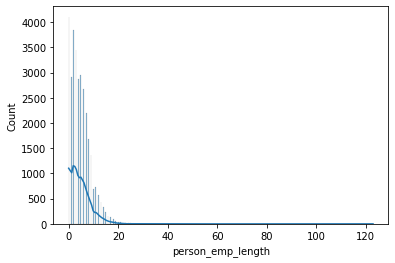

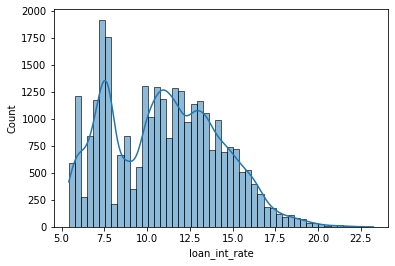

In [68]:
# Checking distribution of features with missing values

for col in missing_cols:
    sns.histplot(data=df, x=col, kde=True)
    plt.show()

In [69]:
# Checking skew

df.skew(numeric_only=True).sort_values(ascending=False)

person_income                 32.865349
person_emp_length              2.614455
person_age                     2.581393
cb_person_cred_hist_length     1.661790
loan_status                    1.364888
loan_amnt                      1.192477
loan_percent_income            1.064669
loan_int_rate                  0.208550
dtype: float64

In [70]:
loan_int_rate_mean = round(df['loan_int_rate'].mean(),2)
df['loan_int_rate'] = df['loan_int_rate'].fillna(loan_int_rate_mean)

person_emp_length_median = round(df['person_emp_length'].median(),2)
df['person_emp_length'] = df['person_emp_length'].fillna(person_emp_length_median)

In [71]:
df.isna().sum().sum()

0

## Viz

<Figure size 720x432 with 0 Axes>

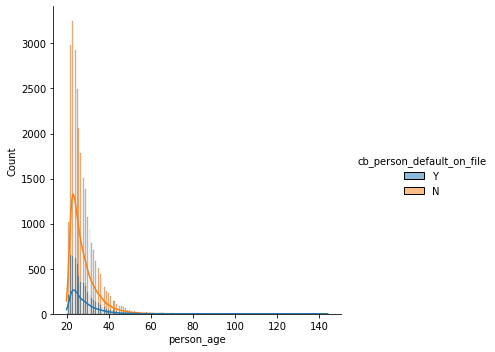

<Figure size 720x432 with 0 Axes>

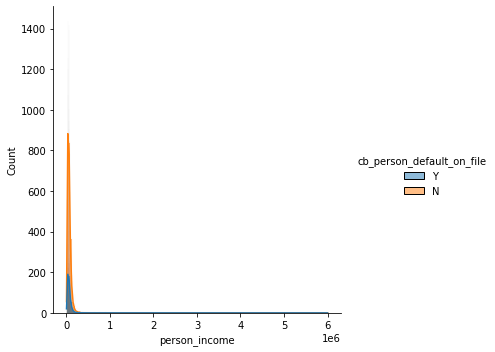

<Figure size 720x432 with 0 Axes>

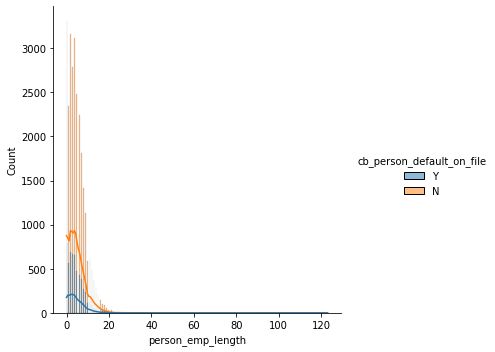

<Figure size 720x432 with 0 Axes>

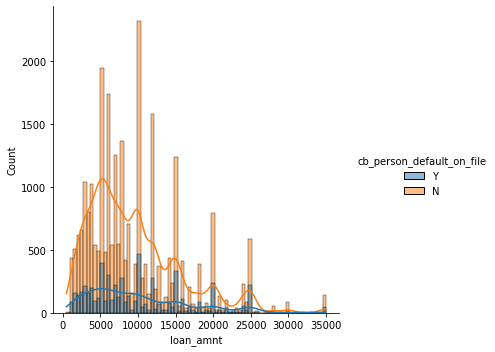

<Figure size 720x432 with 0 Axes>

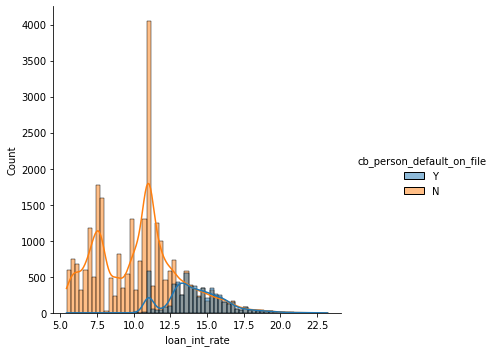

<Figure size 720x432 with 0 Axes>

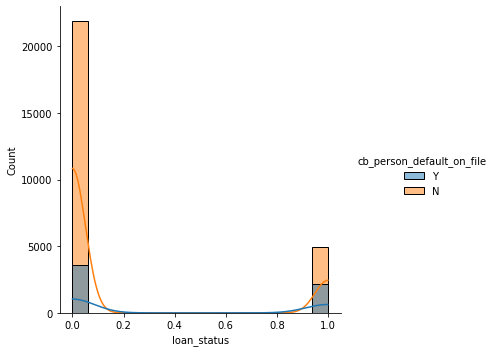

<Figure size 720x432 with 0 Axes>

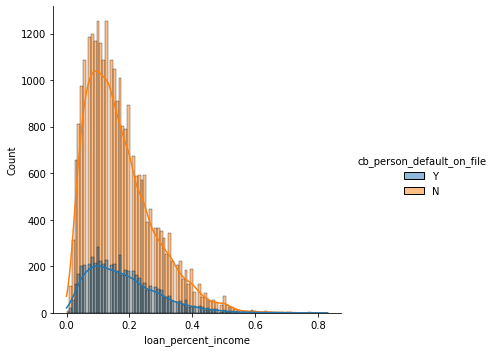

<Figure size 720x432 with 0 Axes>

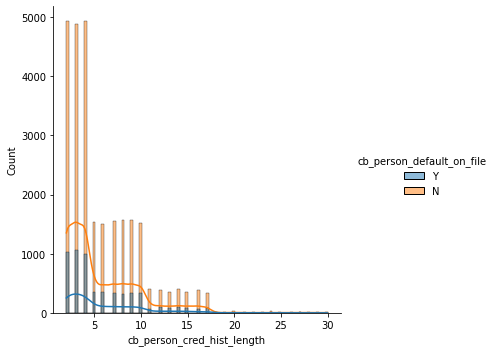

In [72]:
# Plotting of numerical columns

for col in numerical_cols:
    plt.figure(figsize=(10,6))
    sns.displot(data=df, x=col, kde=True, hue='cb_person_default_on_file')
    plt.show()

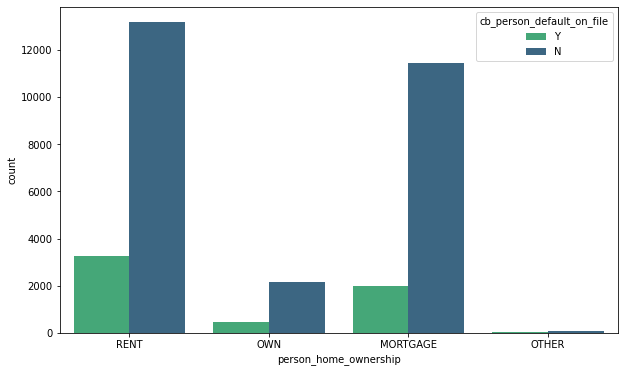

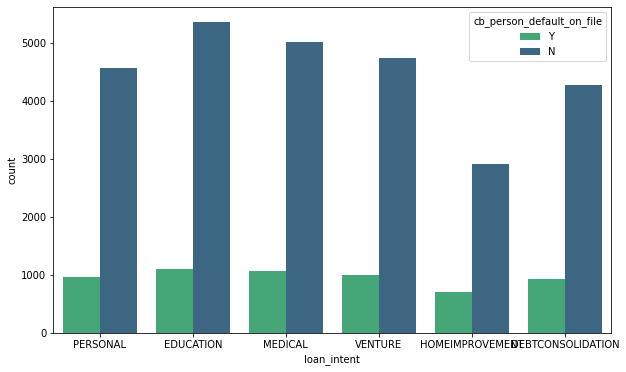

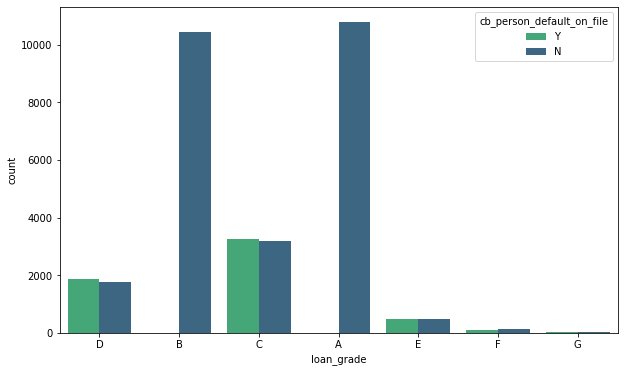

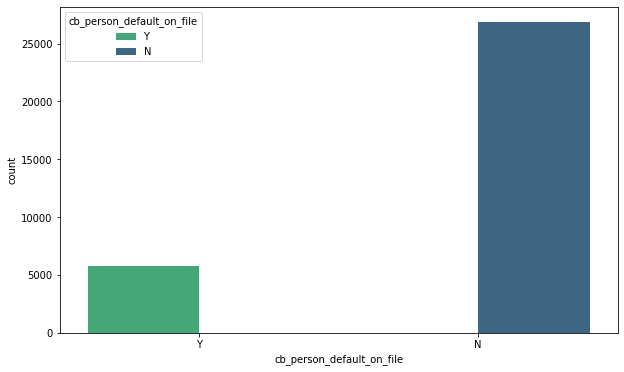

In [73]:
# Plotting of categorical columns

for col in categorical_cols:
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, x=col, palette='viridis_r', hue = 'cb_person_default_on_file')
    plt.show()

<AxesSubplot:>

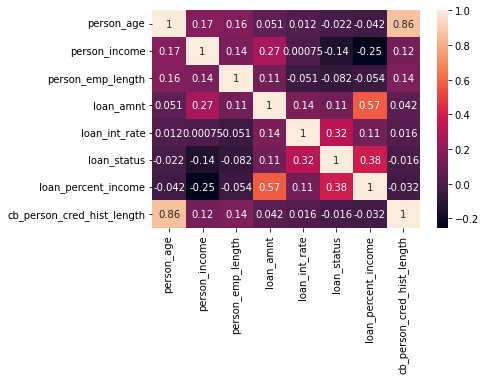

In [74]:
# Correlation

sns.heatmap(df.corr(), annot=True)

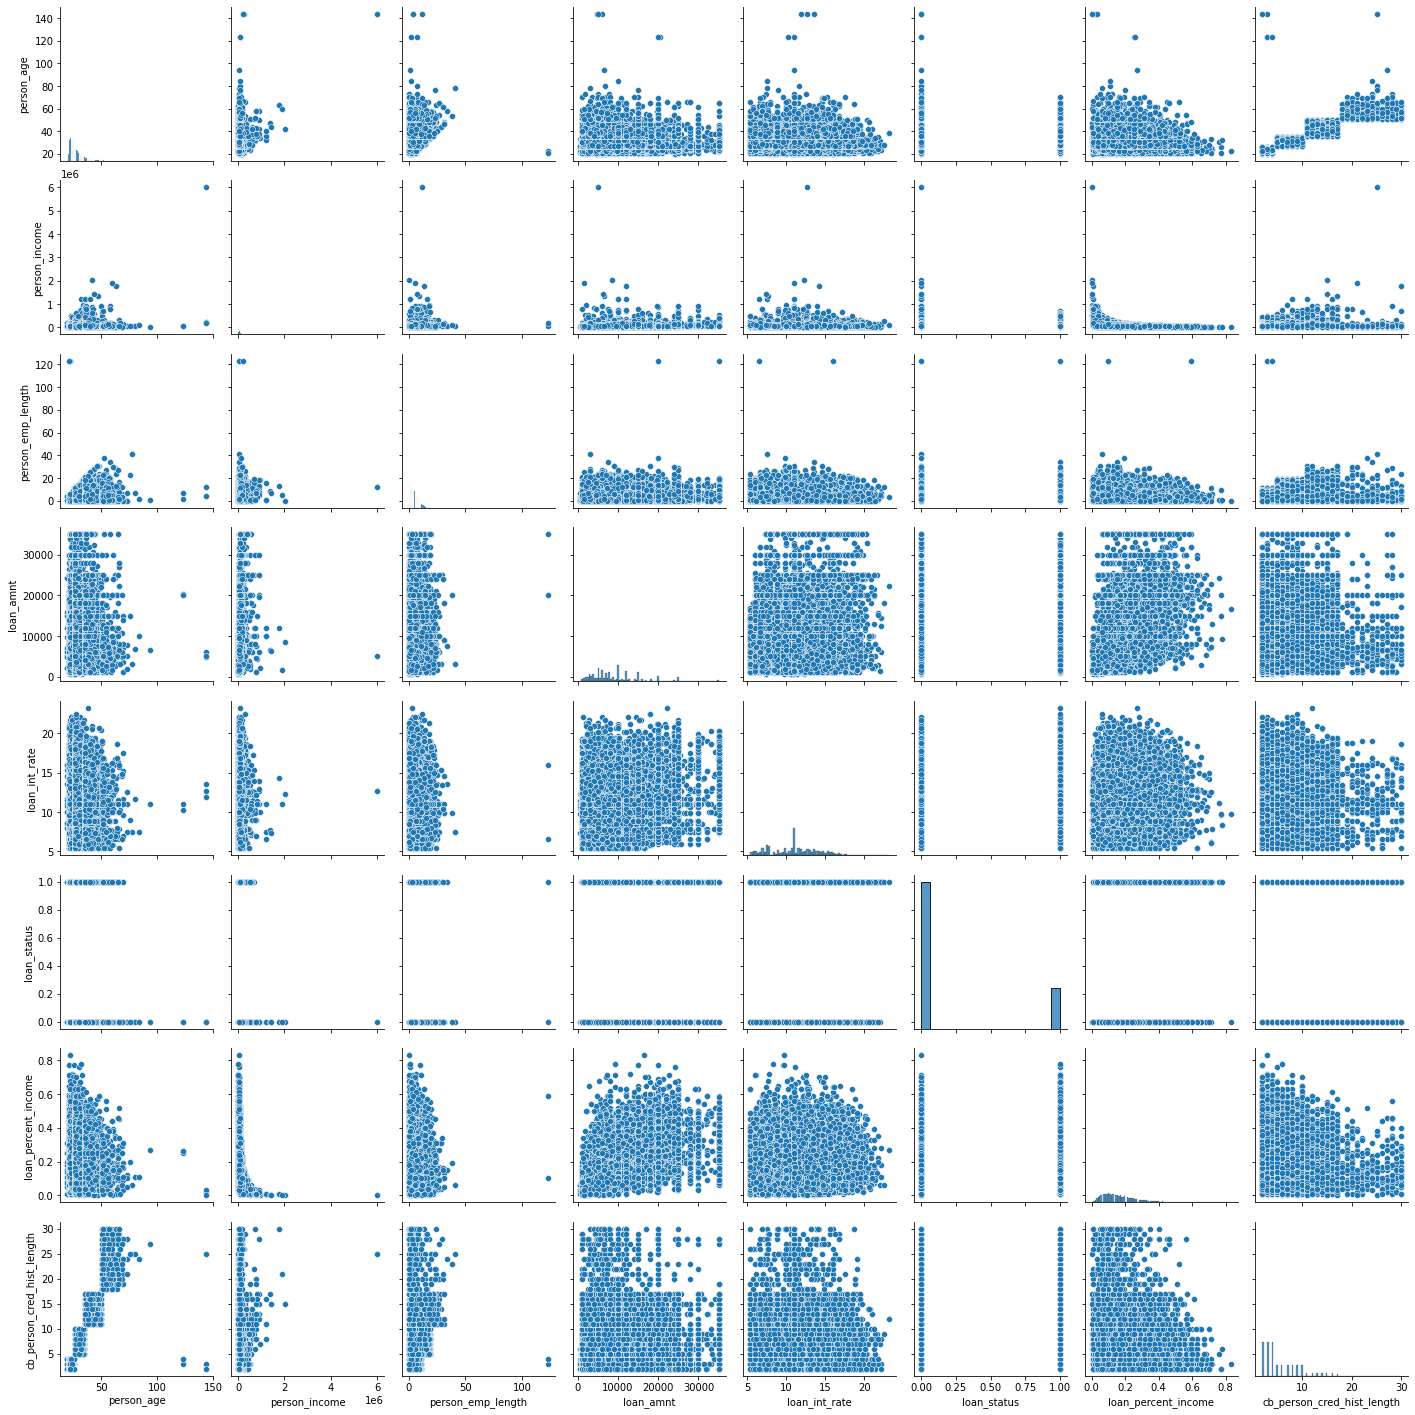

In [75]:
sns.pairplot(df[numerical_cols])

cb_person_cred_host_length has a high collinearity with person_age - Removing person_age

In [76]:
df.drop('person_age', axis=1, inplace=True)

## Encoding the data

In [77]:
# Encoding Categorical Input data
cols_to_encode = ['person_home_ownership', 'loan_intent', 'loan_grade']
df = pd.get_dummies(df, drop_first=True, columns=cols_to_encode)

In [78]:
# Encoding Target

encoder = LabelEncoder()
df['cb_person_default_on_file'] = encoder.fit_transform(df['cb_person_default_on_file'])

# Modeling

Models to be tried:
1. Logistic Regression
2. K-Nearest Neighbour
3. Decision Tree
4. Support Vector Machine
5. Random Forest Classifier
6. Extreme Gradient Boost

In [79]:
models = {
      "LogisticRegression" : LogisticRegression(),
      "KNN" : KNeighborsClassifier(),
      "DecisionTree" : DecisionTreeClassifier(),
      "SVM" : SVC(),
      "RandomForest" : RandomForestClassifier(),
      "XGBoost" : XGBClassifier()
        }

In [80]:
X = df.drop('cb_person_default_on_file', axis=1)
y = df.cb_person_default_on_file

In [81]:
def X_y_train_test_split(df):
    
    # Splitting train and test datasets
    X = df.drop('cb_person_default_on_file', axis=1)
    y = df.cb_person_default_on_file
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1, stratify=y)
    
    return X_train, X_test, y_train, y_test

In [82]:
def scaling_(X_train, X_test):
    # Scaling data
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

In [83]:
def train_test_performance(models, X_train, X_test, y_train, y_test):
    for i in range(len(list(models))):
        model = list(models.values())[i]

        print("Model ----", list(models.keys())[i])

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training performance
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_f1 = f1_score(y_train, y_train_pred, average="weighted")
        train_precision = precision_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)
        train_roc_auc_score = roc_auc_score(y_train, y_train_pred)

        # Testing performance
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred, average="weighted")
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_roc_auc_score = roc_auc_score(y_test, y_test_pred)

        print("Training Performance ----------------------")
        print("Accuracy", train_accuracy)
        print("F1 Score", train_f1)
        print("Precision", train_precision)
        print("Recall", train_recall)
        print("ROC score", train_roc_auc_score)

        print("--------------------------------------------")

        print("Testing Performance ----------------------")
        print("Accuracy", test_accuracy)
        print("F1 Score", test_f1)
        print("Precision", test_precision)
        print("Recall", test_recall)
        print("ROC score", test_roc_auc_score)

        print("\n")

In [84]:
X_train, X_test, y_train, y_test = X_y_train_test_split(df)

X_train_scaled, X_test_scaled = scaling_(X_train, X_test)

train_test_performance(models, X_train_scaled, X_test_scaled, y_train, y_test)

Model ---- LogisticRegression
Training Performance ----------------------
Accuracy 0.832719459791283
F1 Score 0.8397118907447393
Precision 0.5204934341424592
Recall 0.6505844317333996
ROC score 0.7611452901280785
--------------------------------------------
Testing Performance ----------------------
Accuracy 0.8287468030690537
F1 Score 0.836660109932359
Precision 0.5113122171945701
Recall 0.6554524361948956
ROC score 0.7606538047326483


Model ---- KNN
Training Performance ----------------------
Accuracy 0.8905112689643077
F1 Score 0.8905273115324999
Precision 0.6893638170974155
Recall 0.6898781397662274
ROC score 0.8116678428402603
--------------------------------------------
Testing Performance ----------------------
Accuracy 0.8308951406649616
F1 Score 0.8321535181225644
Precision 0.519821328866555
Recall 0.5400232018561485
ROC score 0.7166020865820302


Model ---- DecisionTree
Training Performance ----------------------
Accuracy 0.9992984302376567
F1 Score 0.999297880266372
Precisi

In [85]:
rf_params = {
        "max_depth": [5, 8, 15, None, 10],
        "max_features" : [5, 6, 7, 8, "auto"],
        "min_samples_split": [2, 8, 15, 20],
        "n_estimators": [100, 200, 500, 1000]
}

In [86]:
dt_params = {
            "max_depth" : [3, None],
            "max_features" : list(range(1,10)),
            "min_samples_leaf" : list(range(1,10)),
            "criterion" : ["gini", "entropy"]
}

In [87]:
svm_params = {
            "C" :[1,10,100,1000],
            "gamma" : [1,0.1,0.001,0.0001], 
            "kernel" : ['linear','rbf']
}

In [88]:
model_with_params = [
            ("RF", RandomForestClassifier(), rf_params),
            ("DT", DecisionTreeClassifier(), dt_params),
            ("SVM", SVC(), svm_params)
]

In [33]:
model_param = {}

for name, model, params in model_with_params:
    random = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=80, cv=3, verbose=2, n_jobs=-1)
    random.fit(X_train_scaled, y_train)
    model_param[name] = random.best_params_
    
for model_name in model_param:
    print("Best params for {0}".format(model_name))
    print(model_param[model_name])
    print("\n")

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Fitting 3 folds for each of 80 candidates, totalling 240 fits


D:\Projects\Credit Risk\creditrisk\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 32 is smaller than n_iter=80. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best params for RF
{'n_estimators': 500, 'min_samples_split': 15, 'max_features': 8, 'max_depth': 5}


Best params for DT
{'min_samples_leaf': 6, 'max_features': 5, 'max_depth': 3, 'criterion': 'entropy'}


Best params for SVM
{'kernel': 'rbf', 'gamma': 0.001, 'C': 1000}




In [89]:
models1 = {
      "DecisionTree" : DecisionTreeClassifier(min_samples_leaf=6, max_features=5, max_depth=3, criterion='entropy'),
      "SVM" : SVC(kernel='rbf', gamma=0.001, C=1000, probability=True),
      "RandomForest" : RandomForestClassifier(n_estimators=500, min_samples_split=15, max_features=8, max_depth=5)
}    

In [90]:
train_test_performance(models1, X_train_scaled, X_test_scaled, y_train, y_test)

Model ---- DecisionTree
Training Performance ----------------------
Accuracy 0.8241252302025782
F1 Score 0.7460992623194709
Precision 0.6470588235294118
Recall 0.005471275802039294
ROC score 0.5024162341214082
--------------------------------------------
Testing Performance ----------------------
Accuracy 0.8235294117647058
F1 Score 0.7452826382640748
Precision 0.4666666666666667
Recall 0.004060324825986079
ROC score 0.5015333297214019


Model ---- SVM
Training Performance ----------------------
Accuracy 0.8423221959133561
F1 Score 0.8491711644846971
Precision 0.5418884289375123
Recall 0.6836607809002736
ROC score 0.7799725251320638
--------------------------------------------
Testing Performance ----------------------
Accuracy 0.8264961636828645
F1 Score 0.834594875028513
Precision 0.5063176895306859
Recall 0.6508120649651972
ROC score 0.7574641619075148


Model ---- RandomForest
Training Performance ----------------------
Accuracy 0.8497325265281066
F1 Score 0.8454854862532138
Precis

Looks like SVC is the better performer. Not much overfitting across all the models. 

In [91]:
def roc_curve_plot(models):
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        plt.plot(fpr, tpr, label="{0} ROC - {1}".format(list(models.keys())[i], round(roc_auc_score(y_test, y_pred), 2)))
        plt.plot([0,1], [0,1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC plot")
        plt.legend(loc="lower right")

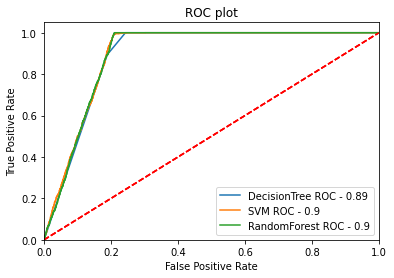

In [92]:
roc_curve_plot(models1)

In [93]:
def precision_recall_plot(models):
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict_proba(X_test_scaled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
        plt.plot(recall, precision, label=list(models.keys())[i])
        plt.title('Precision-Recall Curve')
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.legend(loc="lower right")

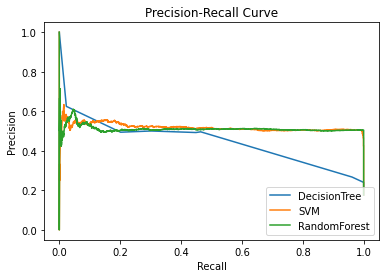

In [94]:
precision_recall_plot(models1)

In [95]:
def error_plot(models):
    for i in range(len(list(models))):
        # learning curve for SVM is taking a lot of time         
        if (list(models.keys())[i] == "SVM"):
            continue
        model = list(models.values())[i]
        cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=1)
        train_sizes , train_scores, test_scores = learning_curve( model, X, y, cv=cv, scoring='f1_weighted')
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
        plt.title(list(models.keys())[i] + "- Performance")
        plt.legend(loc="best")
        plt.show()

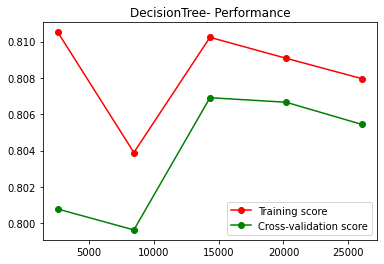

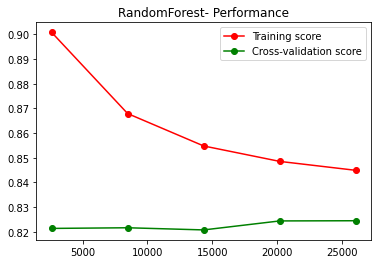

In [96]:
error_plot(models1)

# SVC has a good result, it generalizes well. But is the imbalance in target variable of the dataset causing this issue?!

# Resampling the Data

In [97]:
def counter_(y):
    counter = Counter(y)
    print("{0} majority samples present".format(counter[0]))
    print("{0} minority samples present".format(counter[1]))
    print("Minority-Majority ratio is", counter[1] / counter[0])

In [98]:
X = df.drop('cb_person_default_on_file', axis=1)
y = df.cb_person_default_on_file
counter_(y)

26836 majority samples present
5745 minority samples present
Minority-Majority ratio is 0.21407810403935013


In [99]:
under_sampler = RandomUnderSampler(sampling_strategy=0.40, random_state=1)

under_sampled_X, under_sampled_y = under_sampler.fit_resample(X, y)

In [100]:
counter_(under_sampled_y)

14362 majority samples present
5745 minority samples present
Minority-Majority ratio is 0.4000139256370979


In [101]:
over_sampler = SMOTE(sampling_strategy=0.6, random_state=1)

over_sampled_X, over_sampled_y = over_sampler.fit_resample(under_sampled_X, under_sampled_y)

In [102]:
counter_(over_sampled_y)

14362 majority samples present
8617 minority samples present
Minority-Majority ratio is 0.5999860743629021


In [103]:
X_train, X_test, y_train, y_test = train_test_split(over_sampled_X, over_sampled_y, test_size=0.3, shuffle=True, random_state=1, stratify=over_sampled_y)

X_train_scaled, X_test_scaled = scaling_(X_train, X_test)

train_test_performance(models, X_train_scaled, X_test_scaled, y_train, y_test)

Model ---- LogisticRegression
Training Performance ----------------------
Accuracy 0.8515387006527821
F1 Score 0.8535317572152257
Precision 0.7523545706371191
Recall 0.9005305039787799
ROC score 0.8613365739828247
--------------------------------------------
Testing Performance ----------------------
Accuracy 0.8426167682042356
F1 Score 0.8447706149783406
Precision 0.7410025706940874
Recall 0.8920696324951644
ROC score 0.8525096363914672


Model ---- KNN
Training Performance ----------------------
Accuracy 0.8867889337892446
F1 Score 0.8880612042023317
Precision 0.8039555363072037
Recall 0.9232427055702918
ROC score 0.8940793255296002
--------------------------------------------
Testing Performance ----------------------
Accuracy 0.8385552654482158
F1 Score 0.8405404728462975
Precision 0.7433862433862434
Recall 0.8696324951644101
ROC score 0.8447721538249529


Model ---- DecisionTree
Training Performance ----------------------
Accuracy 0.9995026422132421
F1 Score 0.9995025761051702
Pre

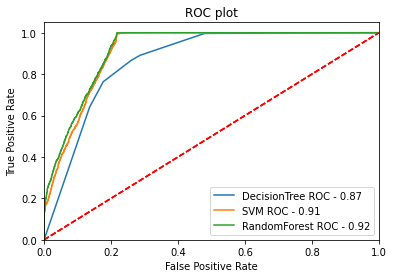

In [104]:
roc_curve_plot(models1)

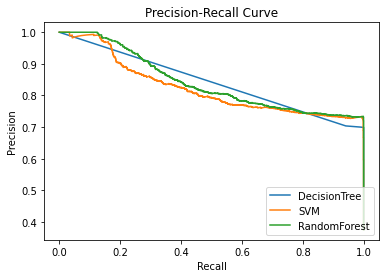

In [105]:
precision_recall_plot(models1)

Precision-Recall curve is way better now!

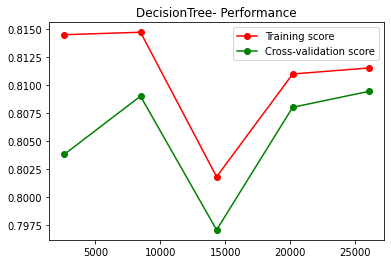

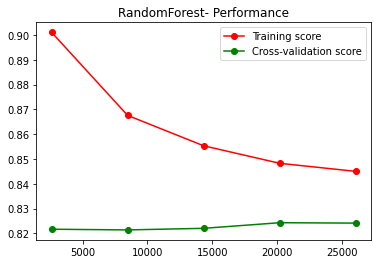

In [106]:
error_plot(models1)

# Inference
## 1. Exchanging the model accuracy for precision-recall is a good call when it comes to imabalanced classification
## 2. Overfitting is reduced significantly